In [2]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sbn
import numpy as np 
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

# load results 

The results file can be generated using `scripts/agg_results.py`

In [3]:
res = pd.read_csv('../output/results.csv')
res = res.assign(name=[f'model={m}_rand={bool(r)}_cag={bool(ca)}' for m,r,ca in res[['model', 'randomize', 'cell_agnostic']].values ])
res[['exp', 'repl']] = res.EXP_ID.str.split(pat='-', expand=True)
res = res.assign(model2 = [m if r == 0 else m + '-rand' for m,r in res[['model', 'randomize']].values])
res.head()

,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,gnn,ignore_cuda,...,r_flat_test,r_flat_val,time_elapsed,eval_at_epoch,EXP_ID,no_residual,name,exp,repl,model2
0,50.0,0.0,32.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,GIN,0.0,...,0.104799,0.103541,440.201324,20.0,exp8-1,NaN,model=gnn_rand=True_cag=False,exp8,1,gnn-rand
1,50.0,0.0,32.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,GIN,0.0,...,0.125788,0.131514,890.559509,40.0,exp8-1,NaN,model=gnn_rand=True_cag=False,exp8,1,gnn-rand
2,50.0,0.0,32.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,GIN,0.0,...,0.129913,0.132156,1339.002441,60.0,exp8-1,NaN,model=gnn_rand=True_cag=False,exp8,1,gnn-rand
3,50.0,0.0,32.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,GIN,0.0,...,0.128868,0.134752,1788.162109,80.0,exp8-1,NaN,model=gnn_rand=True_cag=False,exp8,1,gnn-rand
4,50.0,0.0,32.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,GIN,0.0,...,0.119382,0.119845,2237.689941,100.0,exp8-1,NaN,model=gnn_rand=True_cag=False,exp8,1,gnn-rand


In [4]:
order = np.sort(res.exp.unique())
order

array(['exp1', 'exp10', 'exp11', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6',
       'exp7', 'exp8', 'exp9'], dtype=object)

# Use `val` set to choose best model within each experiment replicate

In [5]:
# metric which will choose "best" model (by max value)
metric = 'r_flat_val' #'r_cell_val' ##'mse_val' #'r2_val' # 'r_flat_val'
lower_is_better = False

In [6]:
bres = res[lambda x: ~x[metric].isna()].sort_values(metric, ascending=lower_is_better).drop_duplicates(['EXP_ID', 'model', 'randomize', 'cell_agnostic'])

bres.head()

,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,gnn,ignore_cuda,...,r_flat_test,r_flat_val,time_elapsed,eval_at_epoch,EXP_ID,no_residual,name,exp,repl,model2
7778,256.0,1.0,124.0,mse,../output/exp10-3//proc/,cpu,0.00,100.0,NaN,0.0,...,0.539442,0.581048,427.859100,80.0,exp10-3,NaN,model=nn_rand=False_cag=True,exp10,3,nn
6973,256.0,1.0,32.0,mse,../output/exp10-1//proc/,cpu,0.00,100.0,NaN,0.0,...,0.550658,0.568264,457.734955,60.0,exp10-1,NaN,model=nn_rand=False_cag=True,exp10,1,nn
6833,50.0,0.0,10.0,mse,../output/exp10-1//proc/,cuda,0.25,100.0,NaN,0.0,...,0.512952,0.562395,3084.307861,60.0,exp10-1,0.0,model=gsnn_rand=False_cag=False,exp10,1,gsnn
7628,50.0,0.0,10.0,mse,../output/exp10-3//proc/,cuda,0.25,100.0,NaN,0.0,...,0.506893,0.558159,5173.685547,80.0,exp10-3,0.0,model=gsnn_rand=False_cag=False,exp10,3,gsnn
2699,256.0,1.0,124.0,mse,../output/exp10-2//proc/,cpu,0.00,100.0,NaN,0.0,...,0.590902,0.547054,757.201843,100.0,exp10-2,NaN,model=nn_rand=False_cag=True,exp10,2,nn


In [16]:
bres[lambda x: (x.EXP_ID == 'exp4-1') & (x.model2 == 'gsnn')][['EXP_ID', 'exp', 'model2', 'dir_name', 'uid', 'model', 'randomize', 'cell_agnostic', 'r_cell_val', 'r_flat_val', 'eval_at_epoch', 'r2_test', 'r2_val']]
# [['channels', 'layers', 'dropout', 'lr']]#

,EXP_ID,exp,model2,dir_name,uid,model,randomize,cell_agnostic,r_cell_val,r_flat_val,eval_at_epoch,r2_test,r2_val
1698,exp4-1,exp4,gsnn,5abe7aa5-0153-4f1f-a58c-7ac25875d723/tb/169165...,5abe7aa5-0153-4f1f-a58c-7ac25875d723,gsnn,0.0,0.0,0.053987,0.437732,NaN,0.10746,0.151969


In [8]:
bres[lambda x: x.exp == 'exp1'][['EXP_ID', 'exp', 'model2', 'dir_name', 'uid', 'model', 'randomize', 'cell_agnostic', 'r_cell_test', 'r_flat_test']][lambda x: x.model == 'gsnn']

,EXP_ID,exp,model2,dir_name,uid,model,randomize,cell_agnostic,r_cell_test,r_flat_test
9666,exp1-1,exp1,gsnn,ea2d2211-932a-4449-81fa-a419bca9a440/tb/169169...,ea2d2211-932a-4449-81fa-a419bca9a440,gsnn,0.0,0.0,0.008150,0.306816
13926,exp1-5,exp1,gsnn,848c19d0-cc9a-4def-9b9a-d089ceb2575e/tb/169219...,848c19d0-cc9a-4def-9b9a-d089ceb2575e,gsnn,0.0,0.0,0.020963,0.325349
13062,exp1-3,exp1,gsnn,80a32797-2b4e-4e11-935d-62461d60a5b6/tb/169169...,80a32797-2b4e-4e11-935d-62461d60a5b6,gsnn,0.0,0.0,0.054350,0.351784
8432,exp1-2,exp1,gsnn,e1279e20-e877-46a4-a123-e304bc658a07/tb/169168...,e1279e20-e877-46a4-a123-e304bc658a07,gsnn,0.0,0.0,0.050322,0.314203
9503,exp1-1,exp1,gsnn-rand,44f68786-695e-4d7b-be92-535e9525aa5b/tb/169169...,44f68786-695e-4d7b-be92-535e9525aa5b,gsnn,1.0,0.0,0.003575,0.060070
13159,exp1-3,exp1,gsnn-rand,c8be42d3-7e2c-42ed-a087-287c3772f862/tb/169169...,c8be42d3-7e2c-42ed-a087-287c3772f862,gsnn,1.0,0.0,0.004795,0.261119
8420,exp1-2,exp1,gsnn-rand,d9a5a642-175a-49f4-92a7-617a1900518c/tb/169169...,d9a5a642-175a-49f4-92a7-617a1900518c,gsnn,1.0,0.0,0.020526,0.233882
13722,exp1-5,exp1,gsnn-rand,26494023-b78a-4810-8663-fd38a7213571/tb/169220...,26494023-b78a-4810-8663-fd38a7213571,gsnn,1.0,0.0,0.009739,0.212154


In [9]:
order = [x for x in ['exp' + str(i) for i in range(12)] if x in bres.exp.unique()]
order

['exp1',
 'exp2',
 'exp3',
 'exp4',
 'exp5',
 'exp6',
 'exp7',
 'exp8',
 'exp9',
 'exp10',
 'exp11']

In [10]:
group1.merge(group2, on=['EXP_ID'], how='inner')

NameError: name 'group1' is not defined

# Paired T-Test Comparison

In [16]:
bres[lambda x: (x.exp == 'exp10') & (x.model == 'gsnn') & (x.randomize == 0) & (x.cell_agnostic == 0)]

,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,gnn,ignore_cuda,...,r_flat_test,r_flat_val,time_elapsed,eval_at_epoch,EXP_ID,no_residual,name,exp,repl,model2
6833,50.0,0.0,10.0,mse,../output/exp10-1//proc/,cuda,0.25,100.0,NaN,0.0,...,0.512952,0.562395,3084.307861,60.0,exp10-1,0.0,model=gsnn_rand=False_cag=False,exp10,1,gsnn
7628,50.0,0.0,10.0,mse,../output/exp10-3//proc/,cuda,0.25,100.0,NaN,0.0,...,0.506893,0.558159,5173.685547,80.0,exp10-3,0.0,model=gsnn_rand=False_cag=False,exp10,3,gsnn
2347,50.0,0.0,10.0,mse,../output/exp10-2//proc/,cuda,0.25,100.0,NaN,0.0,...,0.557423,0.530675,2476.155273,60.0,exp10-2,0.0,model=gsnn_rand=False_cag=False,exp10,2,gsnn


In [97]:
metric = 'r_flat_test'

print('\\begin{tabular}{|l|l|l|}')
print('\\hline')
print('EXP. ID & H0 & p-value \\\\ \\hline')

exps = np.sort(bres.exp.unique())

for i in range(12): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')
    df = group1.merge(group2, on=['EXP_ID'], how='inner')
    score1 = df[f'{metric}_x'].values
    score2 = df[f'{metric}_y'].values

    ttest_res = ttest_rel(score1, score2, alternative='two-sided')

    if ttest_res.statistic < 0: 
        print(exp, '&', 'GSNN > NN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  NN performs better than GSNN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')
    else: 
        print(exp, '&', 'NN > GSNN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  GSNN performs better than NN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')

    if ttest_res.pvalue <= 0.05: 
        print('**\\\\ \\hline')
    else: 
        print('\\\\ \\hline')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|}
\hline
EXP. ID & H0 & p-value \\ \hline
exp1 & GSNN > NN & 0.440\\ \hline
exp2 & GSNN > NN & 0.021**\\ \hline
exp3 & GSNN > NN & 0.079\\ \hline
exp4 & GSNN > NN & 0.606\\ \hline
exp5 & GSNN > NN & 0.191\\ \hline
exp6 & GSNN > NN & 0.124\\ \hline
exp7 & GSNN > NN & 0.566\\ \hline
exp8 & GSNN > NN & 0.035**\\ \hline
exp9 & GSNN > NN & 0.582\\ \hline
exp10 & NN > GSNN & 0.024**\\ \hline
exp11 & NN > GSNN & 0.179\\ \hline
\end{tabular}


In [15]:
metric = 'r_cell_test'

print('\\begin{tabular}{|l|l|l|}')
print('\\hline')
print('EXP. ID & H0 & p-value \\\\ \\hline')

exps = np.sort(bres.exp.unique())

for i in range(12): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')
    df = group1.merge(group2, on=['EXP_ID'], how='inner')
    score1 = df[f'{metric}_x'].values
    score2 = df[f'{metric}_y'].values

    ttest_res = ttest_rel(score1, score2, alternative='two-sided')

    if ttest_res.statistic < 0: 
        print(exp, '&', 'GSNN > NN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  NN performs better than GSNN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')
    else: 
        print(exp, '&', 'NN > GSNN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  GSNN performs better than NN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')

    if ttest_res.pvalue <= 0.05: 
        print('**\\\\ \\hline')
    else: 
        print('\\\\ \\hline')

print('\\end{tabular}')


\begin{tabular}{|l|l|l|}
\hline
EXP. ID & H0 & p-value \\ \hline
exp1 & NN > GSNN & 0.256\\ \hline
exp2 & GSNN > NN & 0.856\\ \hline
exp3 & NN > GSNN & 0.006**\\ \hline
exp4 & NN > GSNN & 0.391\\ \hline
exp5 & NN > GSNN & 0.297\\ \hline
exp6 & NN > GSNN & 0.591\\ \hline
exp7 & NN > GSNN & 0.709\\ \hline
exp8 & NN > GSNN & 0.784\\ \hline
exp9 & NN > GSNN & 0.653\\ \hline
exp10 & NN > GSNN & 0.024**\\ \hline
exp11 & NN > GSNN & 0.899\\ \hline
\end{tabular}


# Number of model parameters: GSNN vs NN

In [17]:
exps = np.sort(bres.exp.unique())


print('\\begin{tabular}{|l|l|l|l|}')
print('\\hline')
print('EXP. ID & Num. GSNN params (min, median, max) & Num. NN params (min, median, max) & Ratio of Median Num. params \\\\ \\hline')

rs = []
for i in range(12): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')
    df = group1.merge(group2, on=['EXP_ID'], how='inner')

    n1 = df.n_params_x.median()
    n2 = df.n_params_y.median()

    ratio_of_params_nn_vs_gsnn = n2 / n1
    rs.append(ratio_of_params_nn_vs_gsnn)

    print(exp, '&', f'{int(df.n_params_x.min())}, {int(df.n_params_x.median())}, {int(df.n_params_x.max())}', '&', f'{int(df.n_params_y.min())}, {int(df.n_params_y.median())}, {int(df.n_params_y.max())}', '&', f'{ratio_of_params_nn_vs_gsnn:.1f}', end=' \\\\ \\hline\n')

print('AVG.', '&', '', '&', '', '&', f'{np.mean(rs):.1f}', end=' \\\\ \\hline\n')

print('\\end{tabular}')


\begin{tabular}{|l|l|l|l|}
\hline
EXP. ID & Num. GSNN params (min, median, max) & Num. NN params (min, median, max) & Ratio of Median Num. params \\ \hline
exp1 & 21442, 49327, 49327 & 97316, 97316, 97316 & 2.0 \\ \hline
exp2 & 49161, 49171, 112491 & 38514, 160138, 160138 & 3.3 \\ \hline
exp3 & 60088, 60098, 139093 & 51788, 105324, 211224 & 1.8 \\ \hline
exp4 & 517674, 517674, 517684 & 118255, 468315, 468315 & 0.9 \\ \hline
exp5 & 242682, 242692, 242712 & 143872, 214852, 285832 & 0.9 \\ \hline
exp6 & 343466, 343466, 343466 & 221315, 436055, 436055 & 1.3 \\ \hline
exp7 & 257516, 582246, 582256 & 435880, 435880, 850960 & 0.7 \\ \hline
exp8 & 280857, 280857, 280857 & 163209, 163209, 323349 & 0.6 \\ \hline
exp9 & 362646, 362646, 362656 & 332866, 665666, 1295186 & 1.8 \\ \hline
exp10 & 191562, 191562, 191562 & 119660, 119660, 239000 & 0.6 \\ \hline
exp11 & 288580, 666300, 666310 & 552837, 1076877, 1076877 & 1.6 \\ \hline
AVG. &  &  & 1.4 \\ \hline
\end{tabular}


# Computational Complexity of the GSNN method

In [18]:
exps = np.sort(bres.exp.unique())
exp_order = [f'exp{i}' for i in range(12) if f'exp{i}' in exps]


timeres = res.groupby(['exp', 'model'])[['time_elapsed']].median().reset_index().pivot(index='exp', columns='model', values='time_elapsed')
timeres = timeres.assign(**{'gnn (min)':lambda x: x.gnn/60, 'gsnn (min)':lambda x: x.gsnn/60, 'nn (min)':lambda x: x.nn/60})
timeres = timeres.assign(gsnn_div_nn = lambda x: x.gsnn / x.nn, gsnn_div_gnn= lambda x: x.gsnn / x.gnn)
timeres = timeres.loc[exp_order, ['gsnn (min)', 'gnn (min)', 'nn (min)', 'gsnn_div_nn', 'gsnn_div_gnn']]

print('\\begin{tabular}{|l|l|l|l|l|l|}')
print('\\hline')
print('EXP. & GSNN (min) & GNN (min) & NN (min) & GSNN / NN & GSNN / GNN \\\\ \\hline')


for exp,row in timeres.iterrows(): 
    print(exp, '&', ' & '.join([str(f'{x:.1f}') for x in row.values]), end=' \\\\ \\hline\n')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|}
\hline
EXP. & GSNN (min) & GNN (min) & NN (min) & GSNN / NN & GSNN / GNN \\ \hline
exp1 & 22.9 & 12.3 & 6.2 & 3.7 & 1.9 \\ \hline
exp2 & 21.3 & 11.6 & 7.0 & 3.1 & 1.8 \\ \hline
exp3 & 53.9 & 22.2 & 9.4 & 5.7 & 2.4 \\ \hline
exp4 & 487.7 & 84.0 & 26.8 & 18.2 & 5.8 \\ \hline
exp5 & 63.6 & 18.3 & 6.9 & 9.2 & 3.5 \\ \hline
exp6 & 279.6 & 90.6 & 19.8 & 14.1 & 3.1 \\ \hline
exp7 & 237.6 & 60.9 & 12.2 & 19.5 & 3.9 \\ \hline
exp8 & 106.5 & 28.8 & 9.3 & 11.5 & 3.7 \\ \hline
exp9 & 217.3 & 59.5 & 12.0 & 18.1 & 3.7 \\ \hline
exp10 & 32.6 & 12.6 & 6.0 & 5.5 & 2.6 \\ \hline
exp11 & 106.4 & 27.4 & 7.4 & 14.4 & 3.9 \\ \hline
\end{tabular}


In [19]:
# proportion of best GSNN models that only required 20 training epochs 
(bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0.)].eval_at_epoch < 21).mean()

0.24390243902439024

# GSNN num layers vs perf. 

In [20]:
# number opf best performing models with each # layer hyperparameters 
bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].groupby('layers')['model'].count()

layers
10.0    14
15.0    26
25.0     1
Name: model, dtype: int64

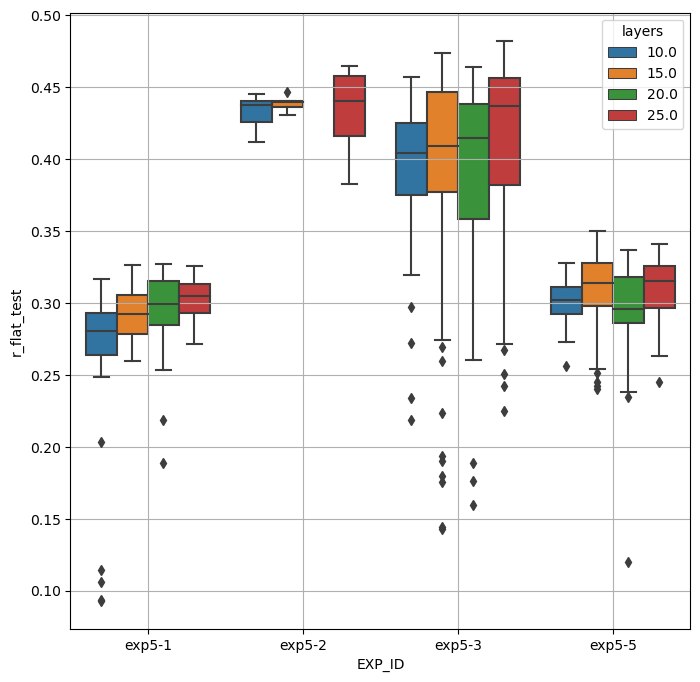

In [51]:
f,ax = plt.subplots(1,1, figsize=(8,8))
sbn.boxplot(y='r_flat_test', x='EXP_ID', hue='layers', data=res[lambda x: (x.model == 'gsnn') & (x.randomize == 0) & (x.exp == 'exp5')], ax=ax)
plt.grid()
plt.show()

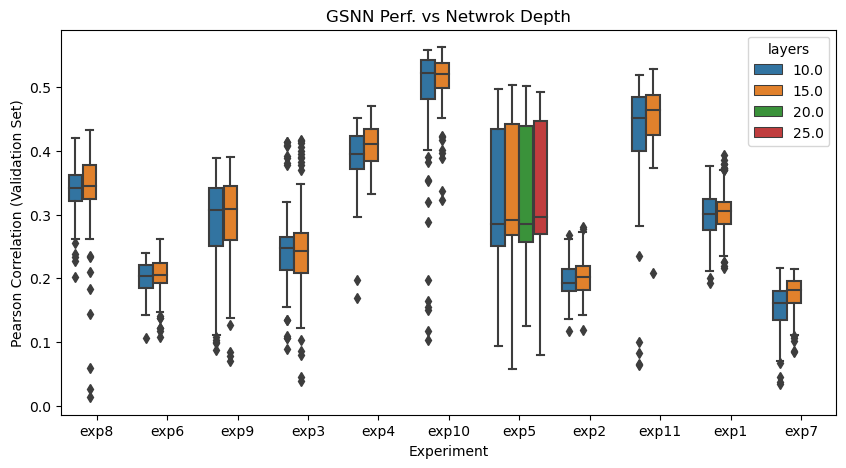

In [98]:
plt.figure(figsize=(10,5))
sbn.boxplot(x='exp', y='r_flat_val', hue='layers', data=res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)])
plt.title('GSNN Perf. vs Netwrok Depth')
plt.xlabel('Experiment')
plt.ylabel('Pearson Correlation (Validation Set)')
plt.show()

In [79]:
df = res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)]
df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')
df = df.assign(exp_norm_r_flat_val=lambda x: (x.r_flat_val - x['r_flat_val', 'mean'])/x['r_flat_val', 'var'])
df.head()

/tmp/ipykernel_6984/2144868085.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')
/tmp/ipykernel_6984/2144868085.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')


,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,gnn,ignore_cuda,...,eval_at_epoch,EXP_ID,no_residual,name,exp,repl,model2,"(r_flat_val, mean)","(r_flat_val, var)",exp_norm_r_flat_val
0,50.0,0.0,10.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,NaN,0.0,...,20.0,exp8-1,0.0,model=gsnn_rand=False_cag=False,exp8,1,gsnn,0.363699,0.000275,59.663306
1,50.0,0.0,10.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,NaN,0.0,...,40.0,exp8-1,0.0,model=gsnn_rand=False_cag=False,exp8,1,gsnn,0.363699,0.000275,49.529642
2,50.0,0.0,10.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,NaN,0.0,...,60.0,exp8-1,0.0,model=gsnn_rand=False_cag=False,exp8,1,gsnn,0.363699,0.000275,49.712246
3,50.0,0.0,10.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,NaN,0.0,...,80.0,exp8-1,0.0,model=gsnn_rand=False_cag=False,exp8,1,gsnn,0.363699,0.000275,42.503385
4,50.0,0.0,10.0,mse,../output/exp8-1//proc/,cuda,0.0,100.0,NaN,0.0,...,100.0,exp8-1,0.0,model=gsnn_rand=False_cag=False,exp8,1,gsnn,0.363699,0.000275,16.221478


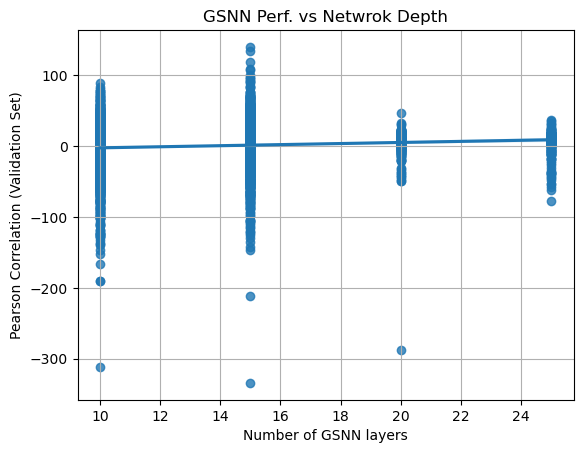

In [81]:
plt.figure()
sbn.regplot(x='layers', y='exp_norm_r_flat_val', data=df)
plt.title('GSNN Perf. vs Netwrok Depth')
plt.xlabel('Number of GSNN layers')
plt.ylabel('Pearson Correlation (Validation Set)')
plt.grid()
plt.show()

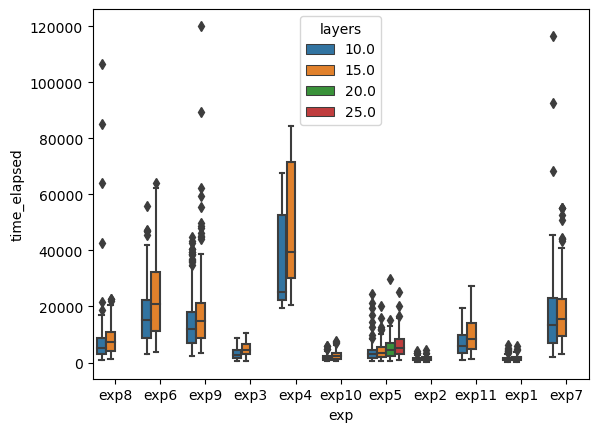

In [54]:
plt.figure()
sbn.boxplot(x='exp', y='time_elapsed', hue='layers', data=res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)])
plt.show()

# GSNN vs NN vs GNN 

Exclude `cell_agnostic` and `randomize` terms. 

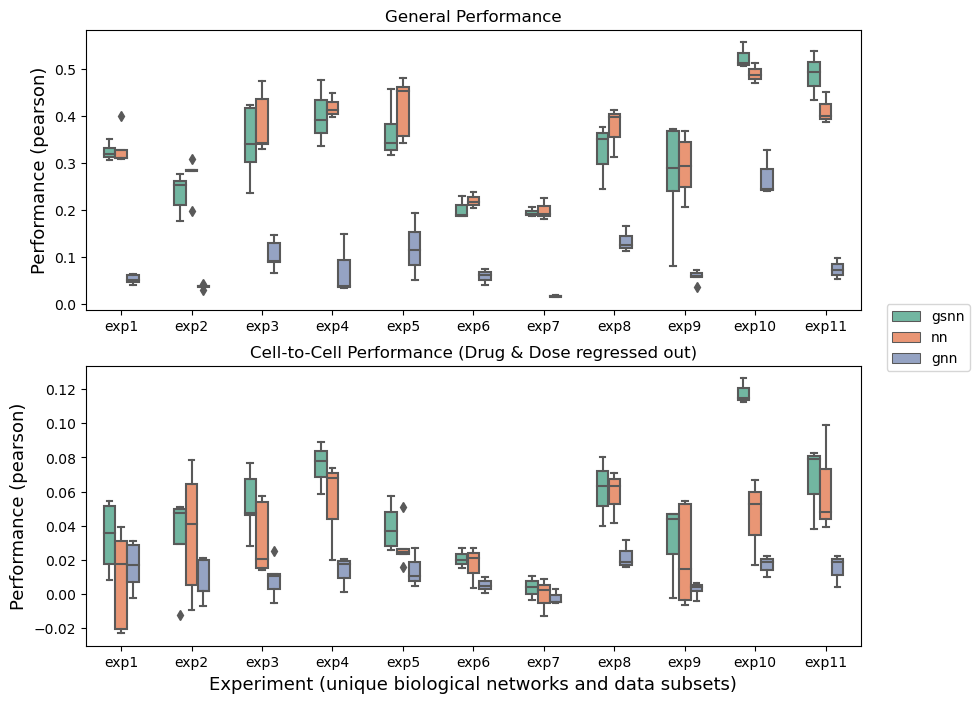

<Figure size 1000x500 with 0 Axes>

In [83]:
fontsize=13

f,axes = plt.subplots(2,1, figsize=(10,8), sharex=False)
g = sbn.boxplot(ax=axes.flat[0], x='exp', y='r_flat_test', hue='model2', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0.)], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
g.legend(loc='right', bbox_to_anchor=(1.15, -0.1), ncol=1)
axes.flat[0].set_xlabel(None)
axes.flat[0].set_ylabel('Performance (pearson)', fontsize=fontsize)
axes.flat[0].set_title('General Performance')

f = plt.figure(figsize=(10,5))
g = sbn.boxplot(ax=axes.flat[1], x='exp', y='r_cell_test', hue='model2', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0.)], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
axes.flat[1].get_legend().set_visible(False)
axes.flat[1].set_ylabel('Performance (pearson)', fontsize=fontsize)
axes.flat[1].set_xlabel('Experiment (unique biological networks and data subsets)', fontsize=fontsize)
axes.flat[1].set_title('Cell-to-Cell Performance (Drug & Dose regressed out)')

plt.tight_layout()
plt.show()

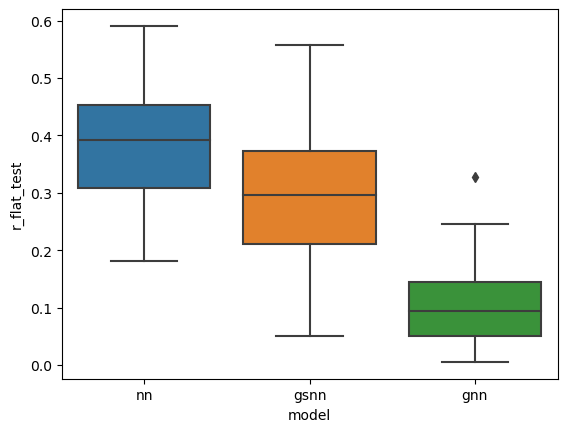

In [84]:
plt.figure()
sbn.boxplot(x='model', y='r_flat_test', data=bres)
plt.show()

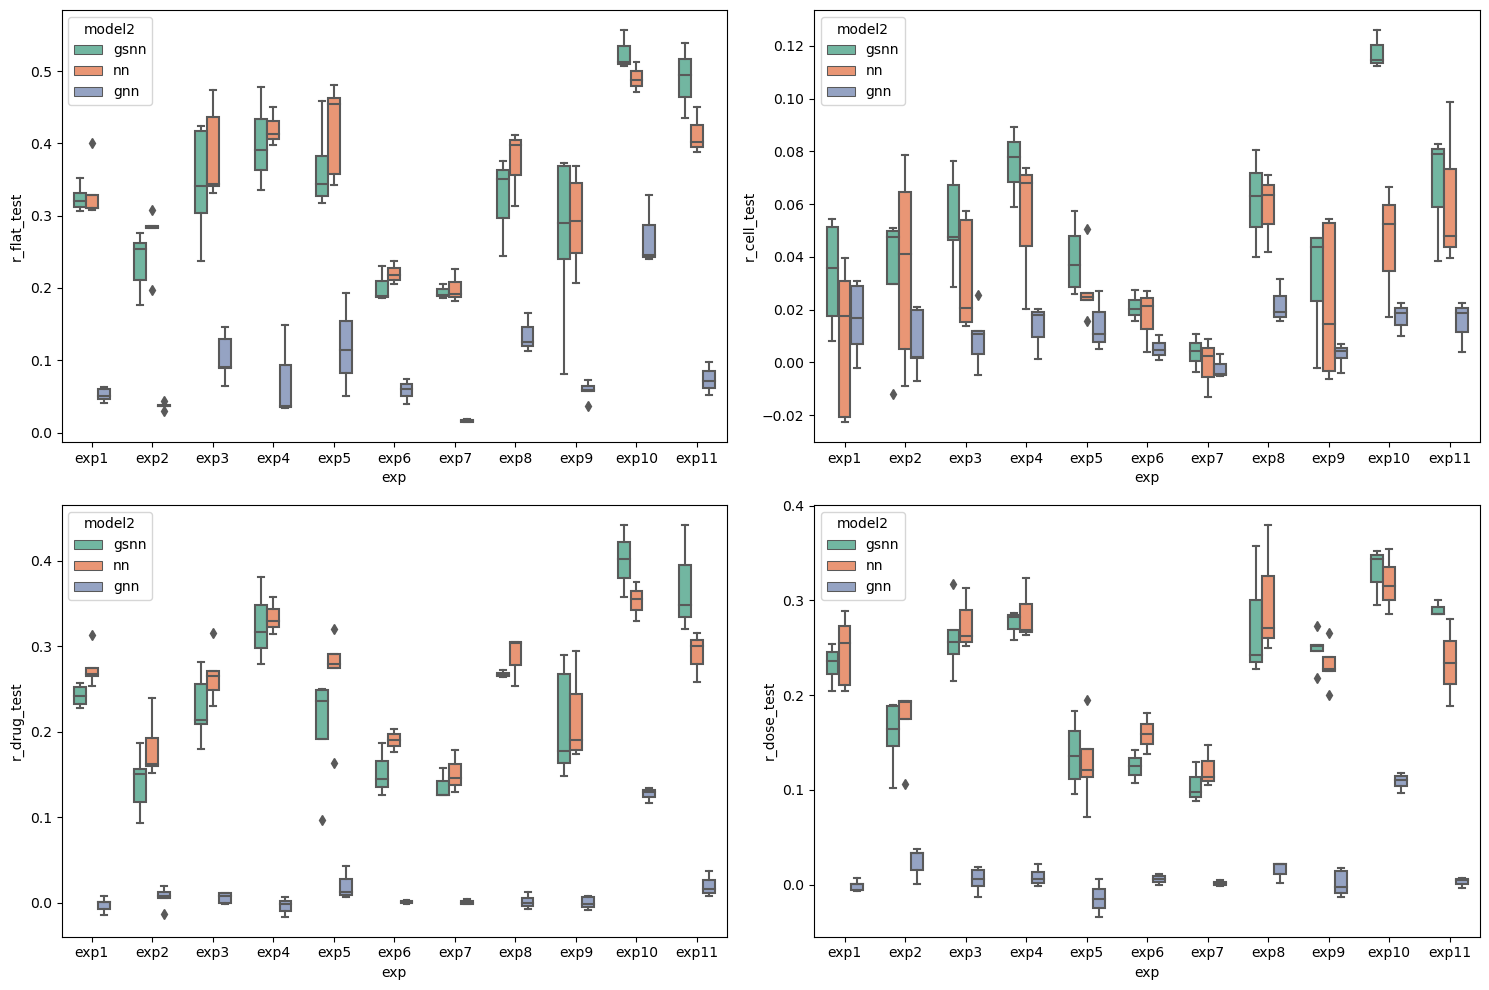

In [85]:
f,axes = plt.subplots(2,2, figsize=(15,10))
for ax, met in zip(axes.flat, ['r_flat_test', 'r_cell_test', 'r_drug_test', 'r_dose_test']):
    sbn.boxplot(x='exp', y=met, hue='model2', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0.)], order=order, width=0.6, orient='v', palette=sbn.color_palette("Set2"), ax=ax)
plt.tight_layout()
plt.show()

# GSNN vs Randomized-GSNN

In [86]:
diffs = []
perc_diffs = []

f=0
for i,row in res[lambda x: (x.model == 'gsnn')][['layers', 'dropout', 'lr', 'channels', 'eval_at_epoch', 'EXP_ID']].drop_duplicates().iterrows(): 

    temp = res[lambda x: (x.layers == row.layers) & (x.dropout == row.dropout) & (x.lr == row.lr) & (x.channels == row.channels) & (x.EXP_ID == row.EXP_ID) & (x.eval_at_epoch == row.eval_at_epoch)]
    
    try: 
        tru = temp[lambda x: x.randomize == 0.]['r_flat_test'].item()
        ran = temp[lambda x: x.randomize == 1.]['r_flat_test'].item()
        diff = tru-ran 
        diffs.append(diff)
        perc_diff = (tru - diff)/diff
        perc_diffs.append(perc_diff)
    except:
        f+=1
        print(f'failed [n={f}]', end='\r')

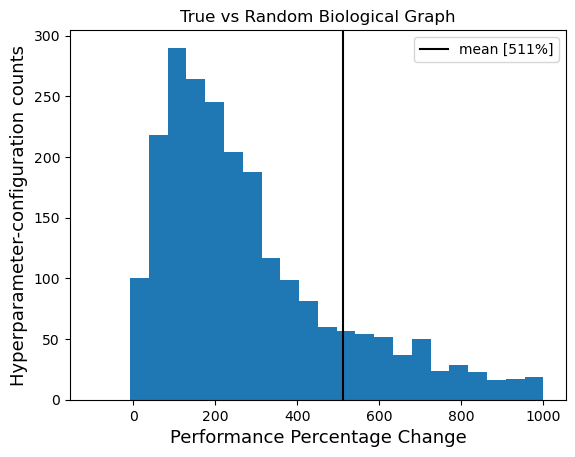

In [87]:
plt.figure()
plt.hist(100*np.array(perc_diffs), bins=np.linspace(-100,1000, 25), density=False)
plt.axvline(np.mean(100*np.array(perc_diffs)), label=f'mean [{100*np.mean(perc_diffs):.0f}%]', c='k')
plt.xlabel('Performance Percentage Change', fontsize=fontsize)
plt.ylabel('Hyperparameter-configuration counts', fontsize=fontsize)
plt.title('True vs Random Biological Graph')
plt.legend()
plt.show()

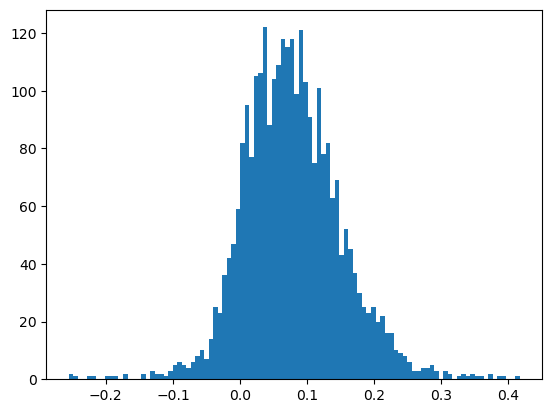

In [88]:
plt.figure()
plt.hist(diffs, bins=100)
plt.show()

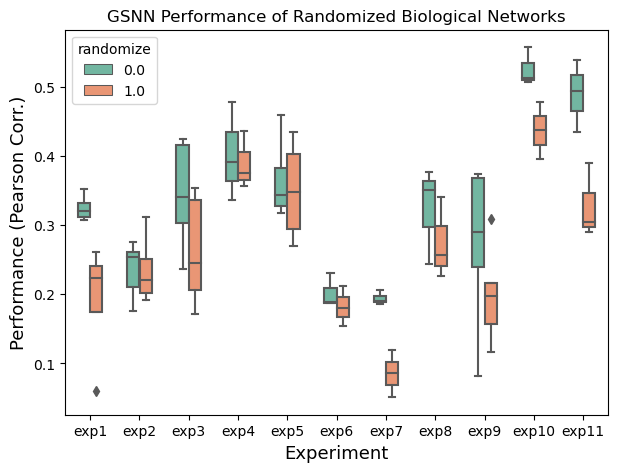

In [89]:
plt.figure(figsize=(7,5))
g = sbn.boxplot(x='exp', y='r_flat_test', hue='randomize', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.model == 'gsnn')], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
plt.xlabel('Experiment', fontsize=fontsize)
plt.ylabel('Performance (Pearson Corr.)', fontsize=fontsize)
plt.title('GSNN Performance of Randomized Biological Networks')
plt.show()

# `cell-agnostic` NN cell-cell performance 

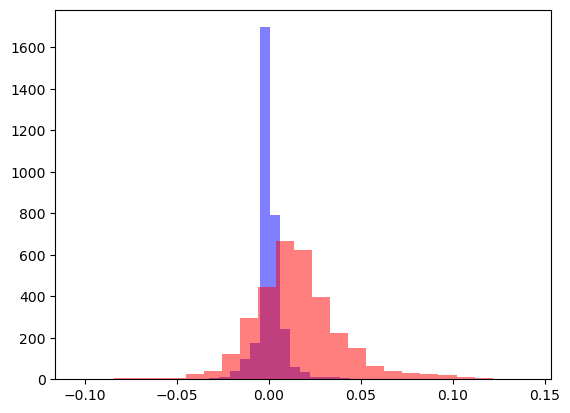

In [90]:
plt.figure()
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 1.)].r_cell_val, bins=25, color='b', alpha=0.5)
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0.)].r_cell_val, bins=25, color='r', alpha=0.5)
plt.show()

# GSNN - what hyper-parameters work best?

In [91]:
bgsnn = bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0.)]

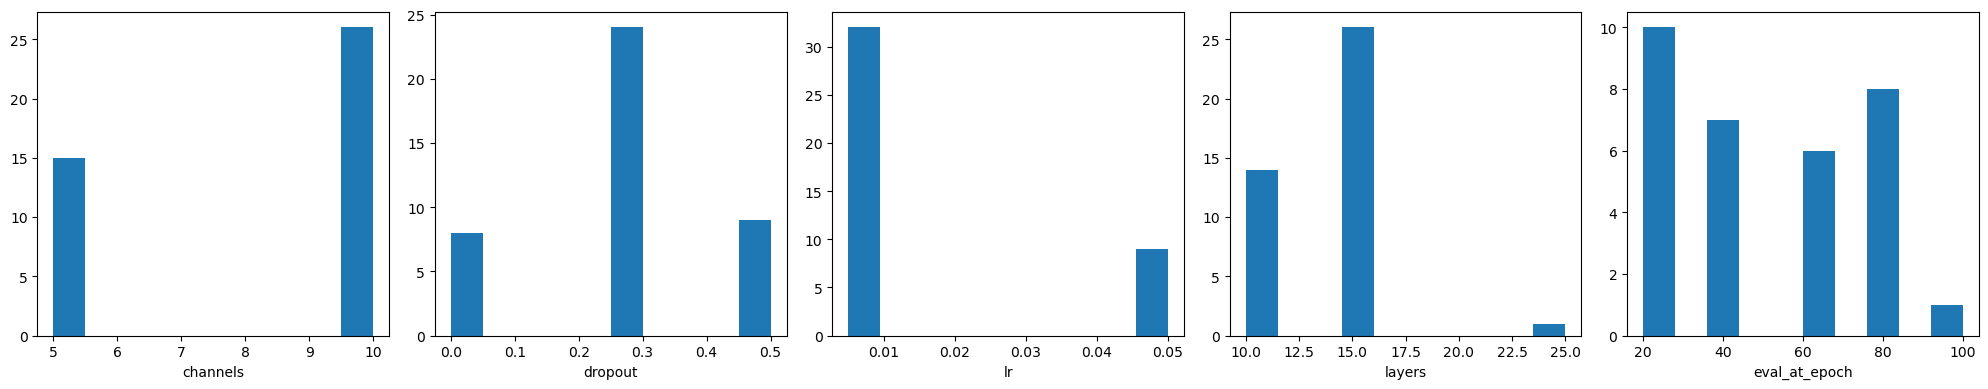

In [92]:
f, axes = plt.subplots(1,5, figsize=(5*4,4))

for ax, hp in zip(axes.flat, ['channels', 'dropout', 'lr', 'layers', 'eval_at_epoch']): 
    ax.hist(bgsnn[hp])
    ax.set_xlabel(hp)

plt.tight_layout()
plt.show()

# GSNN vs NN vs GNN (all hyper-parameter runs)

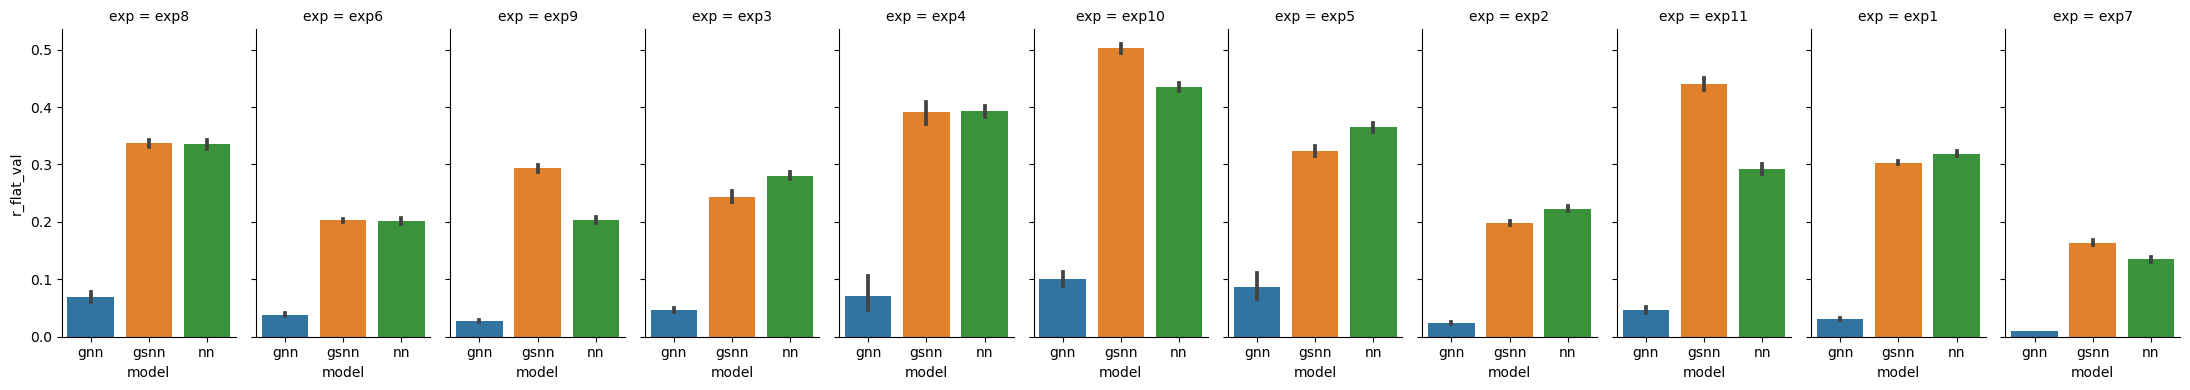

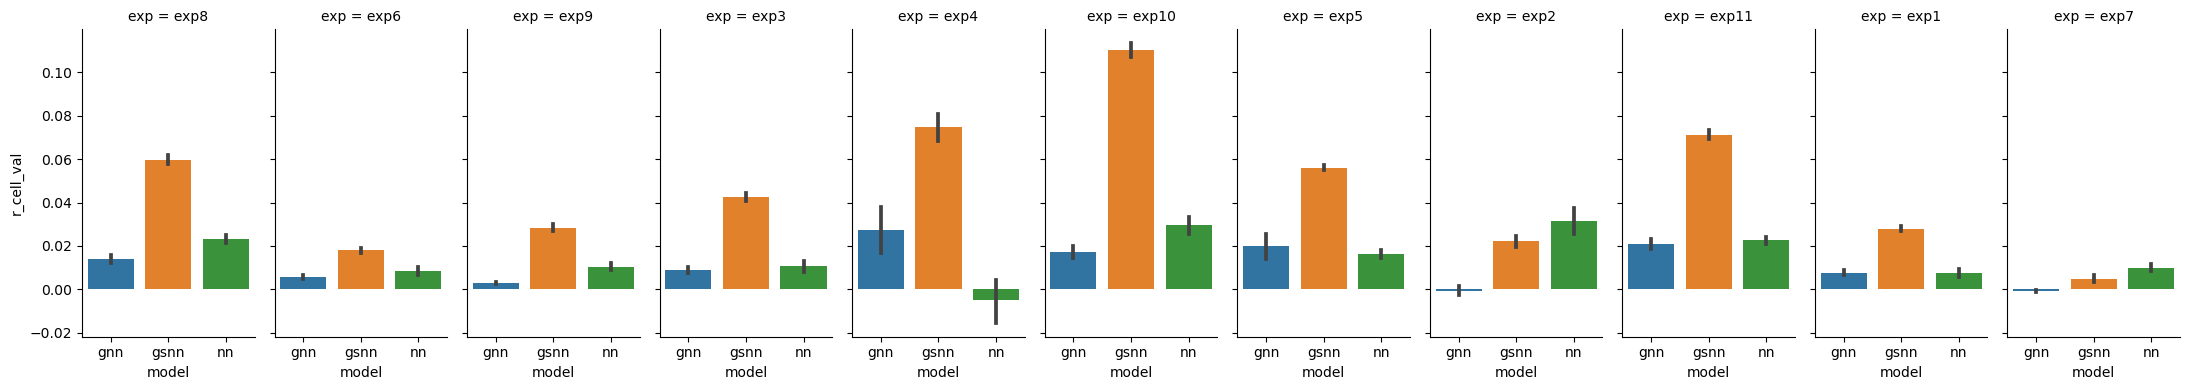

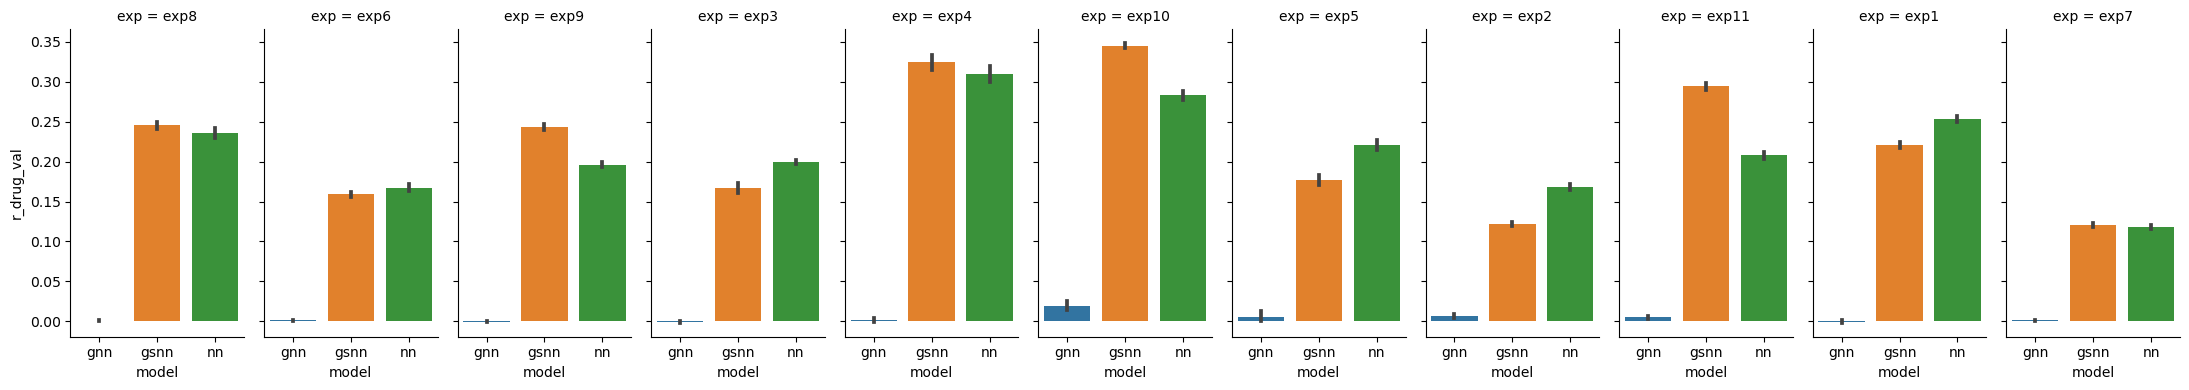

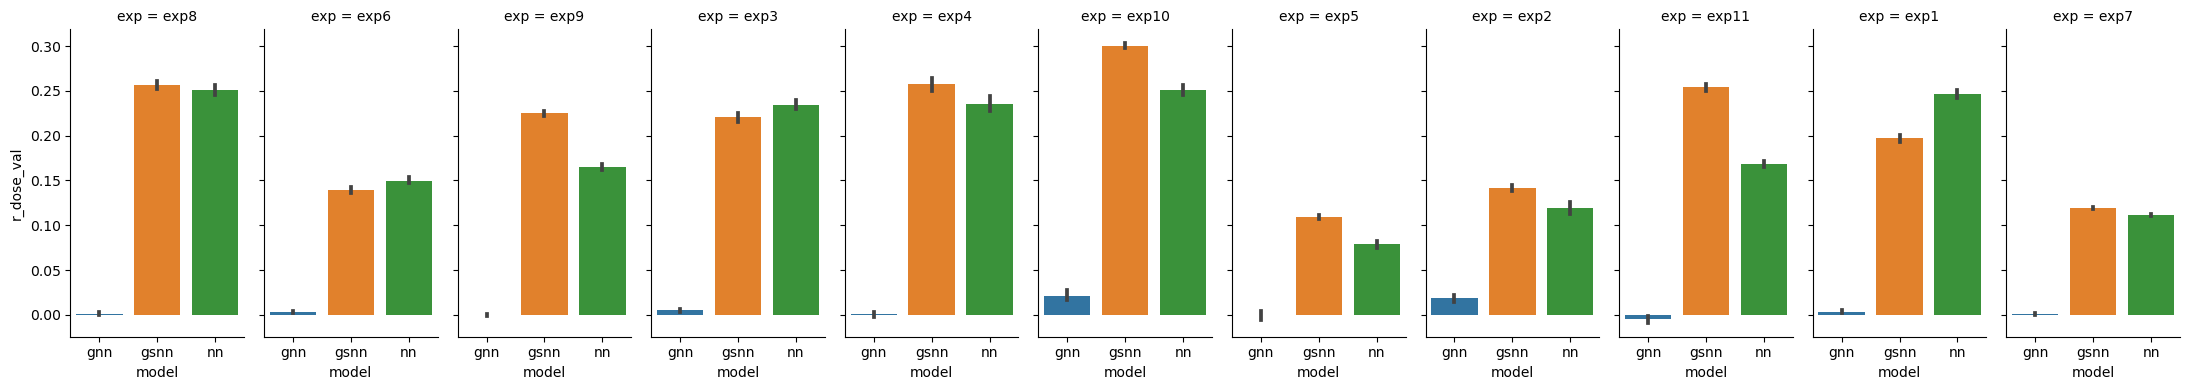

In [93]:
for i,metric in enumerate(['r_flat_val', 'r_cell_val', 'r_drug_val', 'r_dose_val']): 
    sbn.catplot(
        data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], x="model", y=metric, col="exp",
        kind="bar", height=4, aspect=.5)


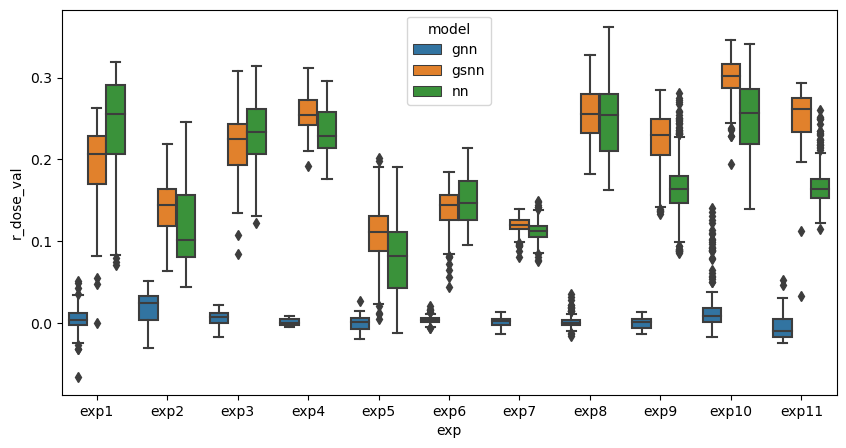

In [94]:
plt.figure(figsize=(10,5))
g = sbn.boxplot(x='exp', y=metric, hue='model', data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], order=order)
plt.show()